# Environment

In [1]:
import torchaudio
import numpy as np
from torch import Tensor
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import find_peaks
from helpers.path_utils import get_base_dir
from helpers.plot import plot_wavelet_spectrogram, plot_audio_fft
from helpers.transform import TrimAfterTrigger, apply_bandpass_filter, min_max_scale

# Raw Heartbeat

Sample rate:  16000


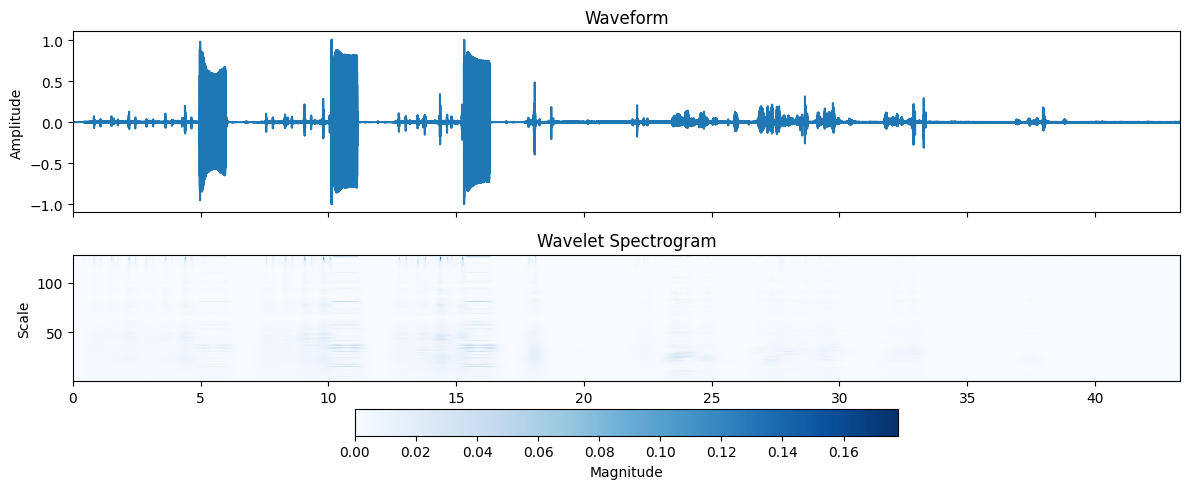

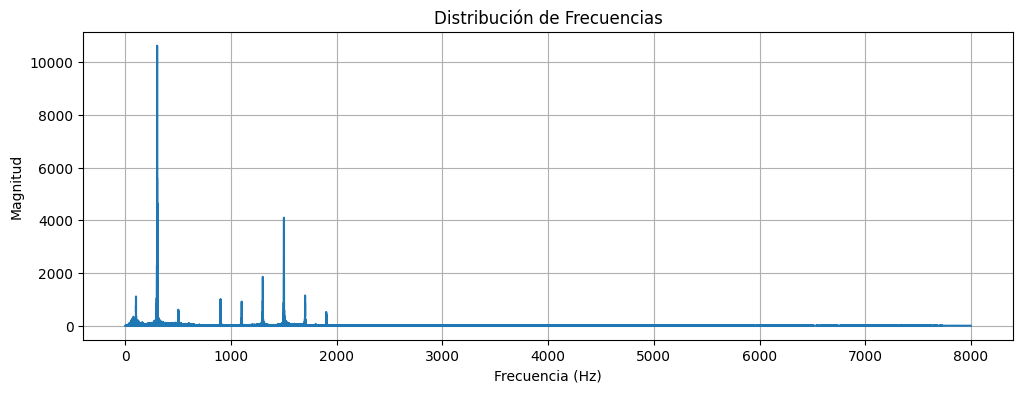

In [2]:
AUDIO_NAME = "test-202407211616.m4a"
MOBILE_AUDIO_DIR = get_base_dir().joinpath(f"data/mobile/{AUDIO_NAME}")

mobile_audio, mobile_sample_rate = torchaudio.load(str(MOBILE_AUDIO_DIR))
print("Sample rate: ", mobile_sample_rate)

plot_wavelet_spectrogram(mobile_audio.numpy(), mobile_sample_rate)
plot_audio_fft(mobile_audio.numpy(), mobile_sample_rate)

Audio(mobile_audio, rate=mobile_sample_rate, autoplay=True)

# Resample to match the digital stethoscope sample rate

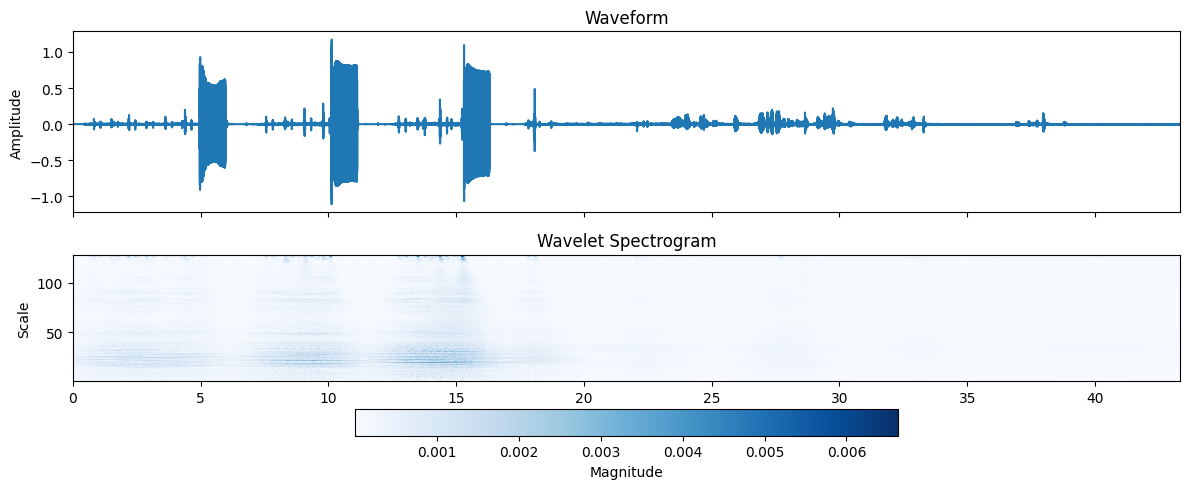

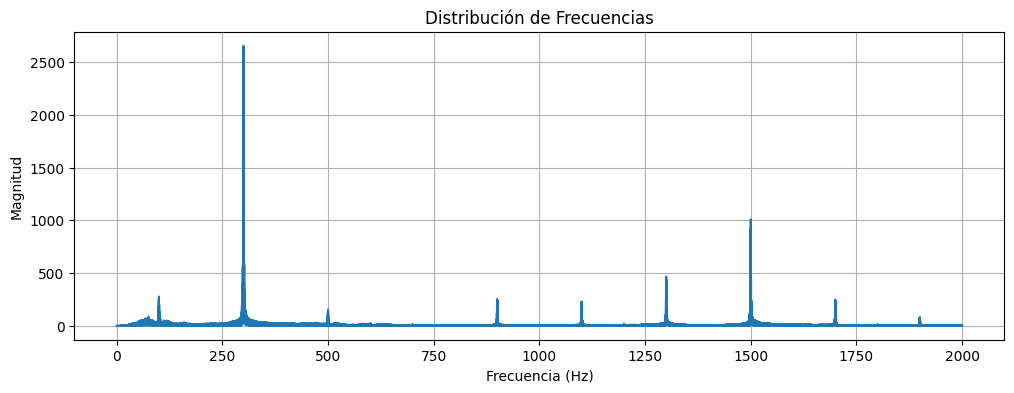

In [3]:
new_sample_rate = 4000

resampler = torchaudio.transforms.Resample(orig_freq=mobile_sample_rate, new_freq=new_sample_rate)

mobile_audio = resampler(mobile_audio)
mobile_sample_rate = new_sample_rate

plot_wavelet_spectrogram(mobile_audio.numpy(), mobile_sample_rate)
plot_audio_fft(mobile_audio.numpy(), mobile_sample_rate)

Audio(mobile_audio, rate=mobile_sample_rate, autoplay=True)

# Focus on synthetic frequency

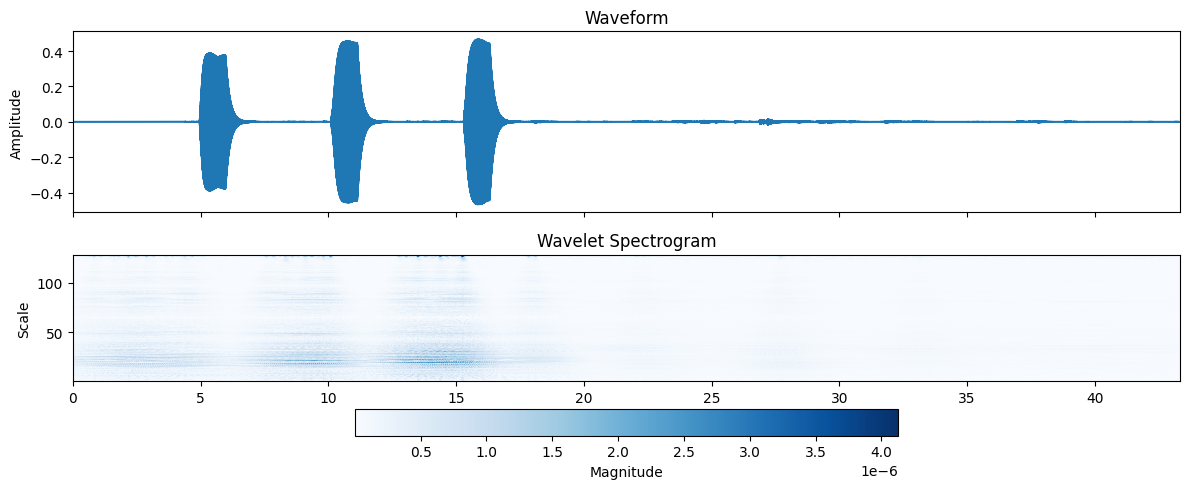

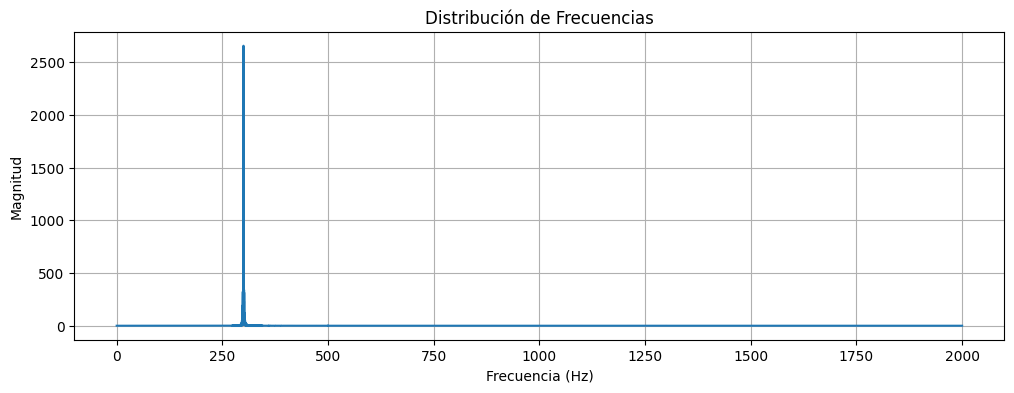

In [4]:
SYNTHETIC_FREQ = 300
low_cutoff = SYNTHETIC_FREQ - 1
high_cutoff = SYNTHETIC_FREQ + 1

filtered_audio = apply_bandpass_filter(
    mobile_audio, mobile_sample_rate, low_cutoff, high_cutoff
)

plot_wavelet_spectrogram(filtered_audio.numpy(), mobile_sample_rate)
plot_audio_fft(filtered_audio.numpy(), mobile_sample_rate)

Audio(filtered_audio, rate=mobile_sample_rate, autoplay=True)

# Downsample and smooth it

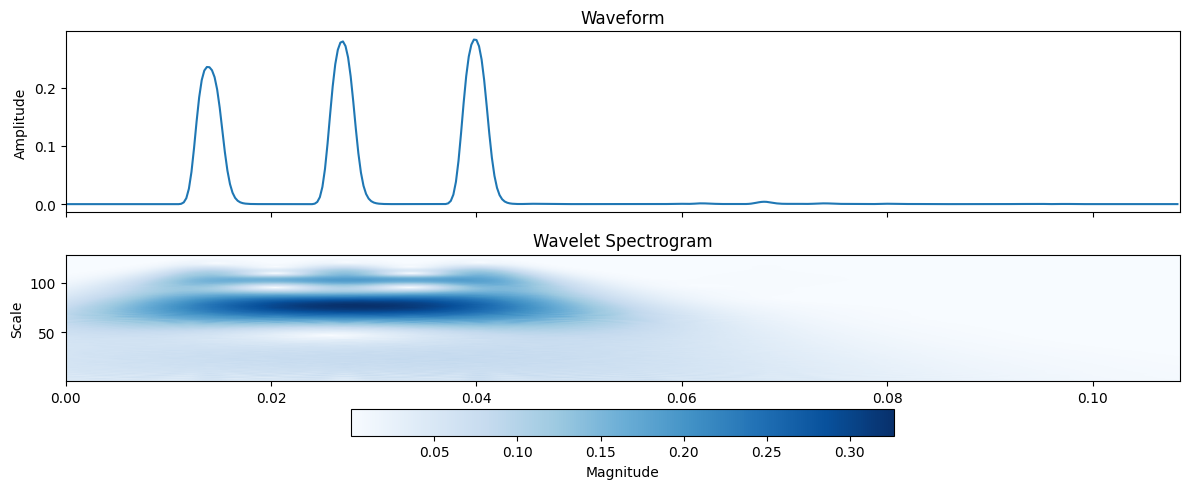

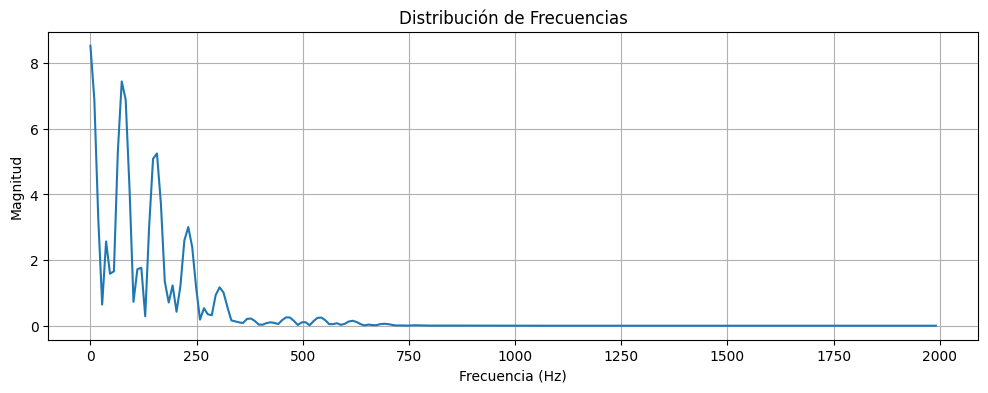

In [5]:
tat = TrimAfterTrigger()
DOWNSAMPLE_FACTOR = 400
SIGMA_SMOOTH = 2

smoothed = tat.abs_downsample_smooth(filtered_audio, DOWNSAMPLE_FACTOR, SIGMA_SMOOTH)
plot_wavelet_spectrogram(smoothed, mobile_sample_rate, downsample_factor=1)
plot_audio_fft(smoothed, mobile_sample_rate)

Audio(smoothed, rate=mobile_sample_rate / DOWNSAMPLE_FACTOR, autoplay=True)

# Find peaks where signal changes

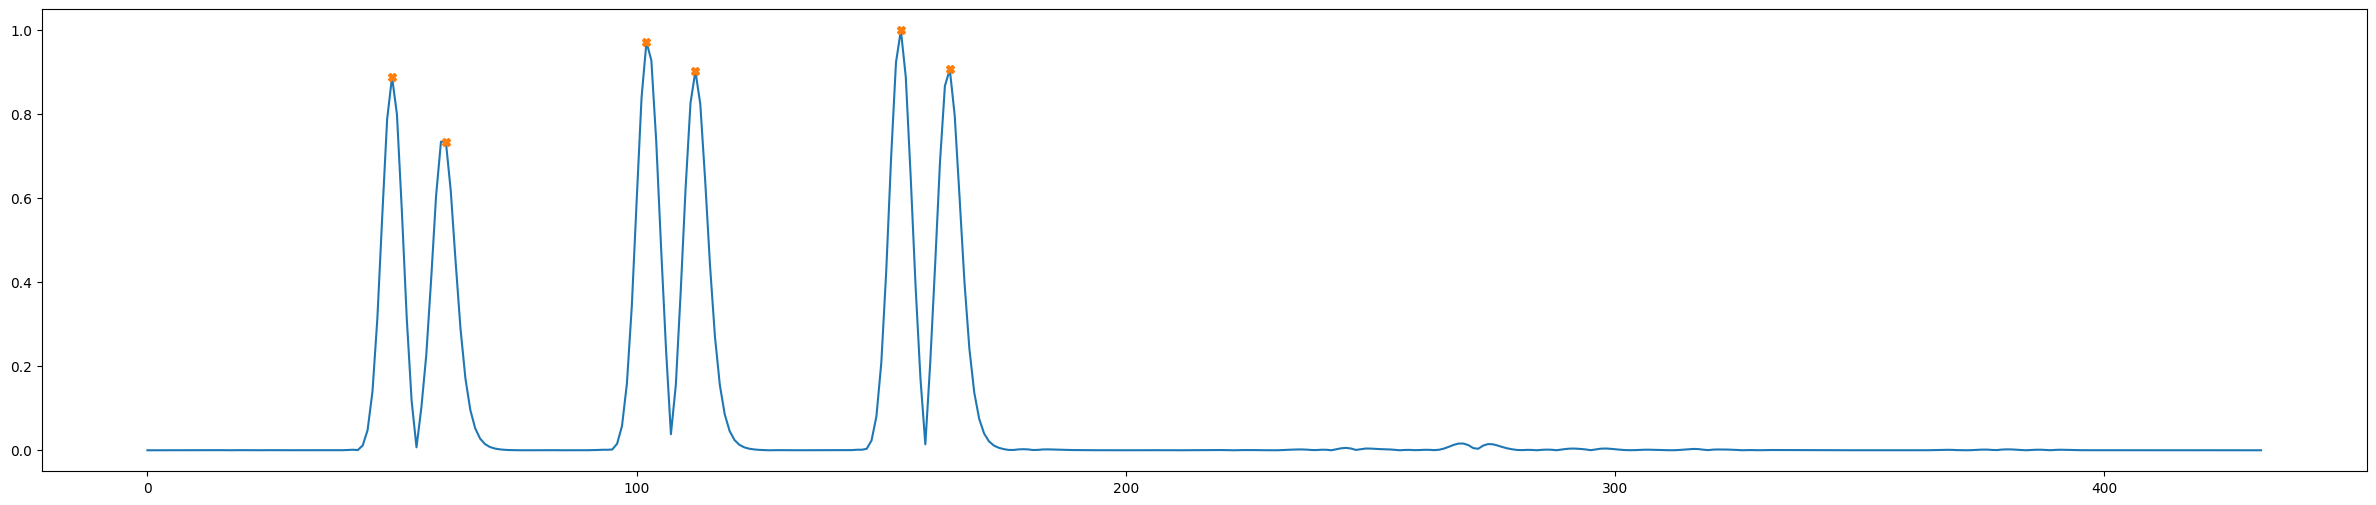

In [6]:
PEAKS_HEIGHT = 0.3
PEAKS_PROMINENCE = 0.0001

smoothed_diff = np.abs(np.diff(smoothed).squeeze())
smoothed_diff = min_max_scale(Tensor(smoothed_diff))
peaks, _ = find_peaks(smoothed_diff, height=PEAKS_HEIGHT, prominence=PEAKS_PROMINENCE)

plt.figure(figsize=(30, 6))
plt.plot(smoothed_diff)
plt.plot(peaks, smoothed_diff[peaks], "X")

In [7]:
peaks

array([ 50,  61, 102, 112, 154, 164])

# Upsample those peaks in the raw audio signal

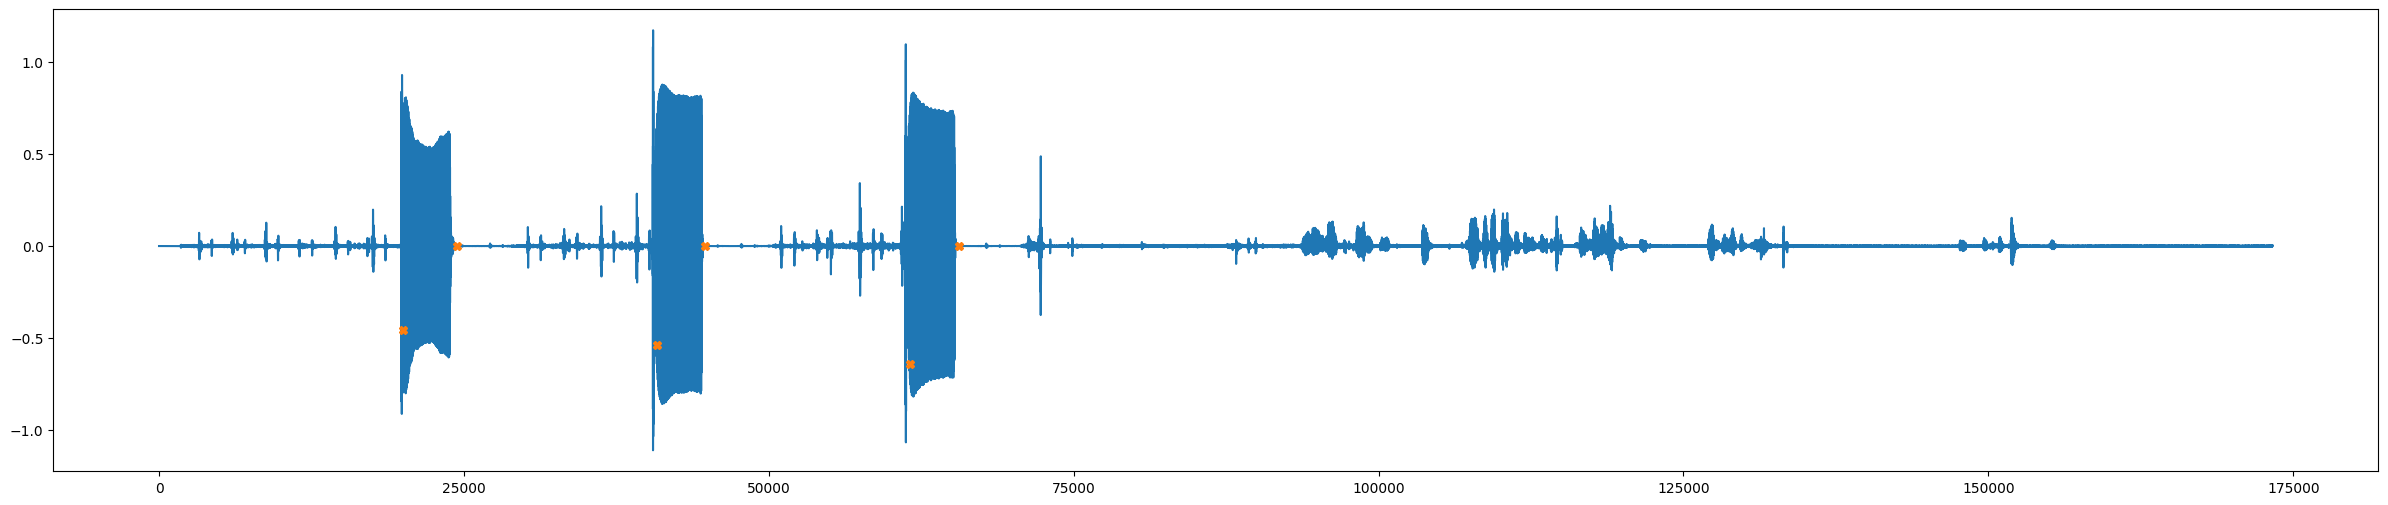

In [8]:
upsampled_peaks = peaks * DOWNSAMPLE_FACTOR

plt.figure(figsize=(30, 6))
plt.plot(mobile_audio.squeeze())
plt.plot(upsampled_peaks, mobile_audio.squeeze()[upsampled_peaks], "X")

# Split signal

In [9]:
split_points = np.concatenate(([0], upsampled_peaks, [mobile_audio.shape[1]]))

audio_tensor = mobile_audio.squeeze()
segments = [
    audio_tensor[split_points[i] : split_points[i + 1]]
    for i in range(len(split_points) - 1)
]

for i, segment in enumerate(segments):
    duration = len(segment) / mobile_sample_rate
    print(f"#{i+1} ({duration}s): {segment}")

#1 (5.0s): tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.4702, -0.1168, -0.6215])
#2 (1.1s): tensor([-4.5749e-01,  1.3725e-01, -1.1708e-01,  ..., -8.0227e-05,
         4.0301e-05, -1.0755e-04])
#3 (4.1s): tensor([ 1.2833e-05,  3.0662e-05,  1.6633e-04,  ..., -3.9898e-01,
        -3.3775e-01, -2.2269e-01])
#4 (1.0s): tensor([-5.3883e-01, -1.2769e-01,  1.9812e-02,  ...,  6.9289e-04,
         4.5614e-04,  3.7242e-05])
#5 (4.2s): tensor([-1.6330e-04, -3.8985e-04, -7.3849e-04,  ..., -3.1740e-01,
        -4.3213e-01, -3.2253e-01])
#6 (1.0s): tensor([-6.4216e-01, -3.3038e-01, -7.1996e-02,  ..., -2.2699e-04,
        -1.4544e-04, -2.3541e-04])
#7 (26.928s): tensor([-2.0566e-04, -7.9528e-05, -1.5957e-04,  ...,  1.8977e-03,
         2.3720e-03,  3.0195e-03])


# Keep just the valid segments

#1 (5.0s): tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.4702, -0.1168, -0.6215])


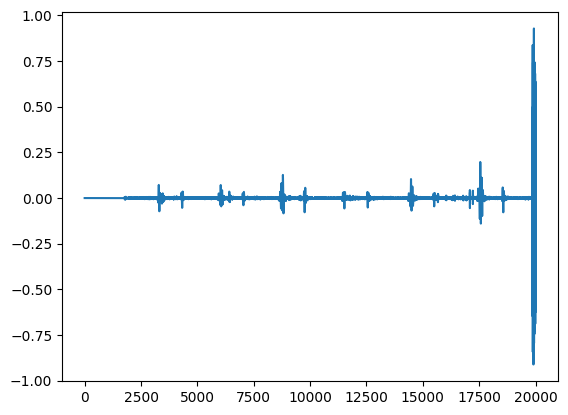

#2 (4.1s): tensor([ 1.2833e-05,  3.0662e-05,  1.6633e-04,  ..., -3.9898e-01,
        -3.3775e-01, -2.2269e-01])


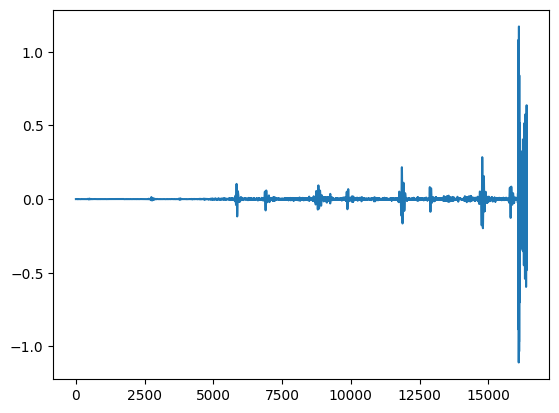

#3 (4.2s): tensor([-1.6330e-04, -3.8985e-04, -7.3849e-04,  ..., -3.1740e-01,
        -4.3213e-01, -3.2253e-01])


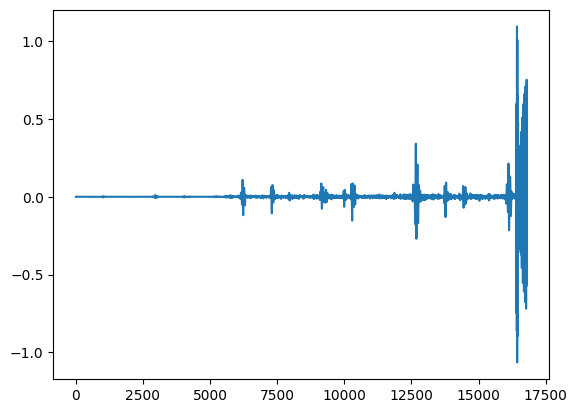

#4 (26.928s): tensor([-2.0566e-04, -7.9528e-05, -1.5957e-04,  ...,  1.8977e-03,
         2.3720e-03,  3.0195e-03])


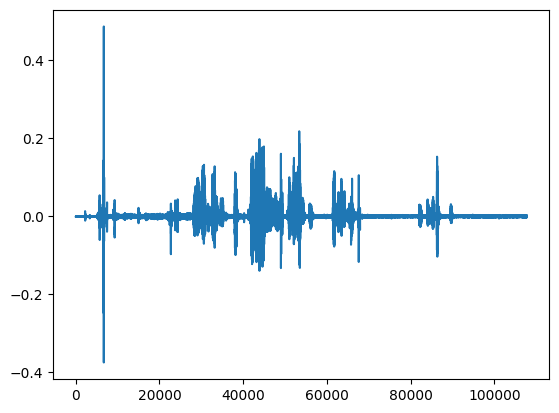

In [10]:
MIN_SECS = 4

filtered_segments = filter(lambda x: len(x) / mobile_sample_rate > MIN_SECS, segments)
valid_segments = list(map(lambda x: x.unsqueeze(0), filtered_segments))

for i, segment in enumerate(valid_segments):
    segment = segment.squeeze()
    duration = len(segment) / mobile_sample_rate

    print(f"#{i+1} ({duration}s): {segment}")
    plt.plot(segment)
    plt.show()

# All wrapped in one function

#1 (28.528s): tensor([0.4917, 0.4920, 0.4917,  ..., 0.4940, 0.4943, 0.4946])


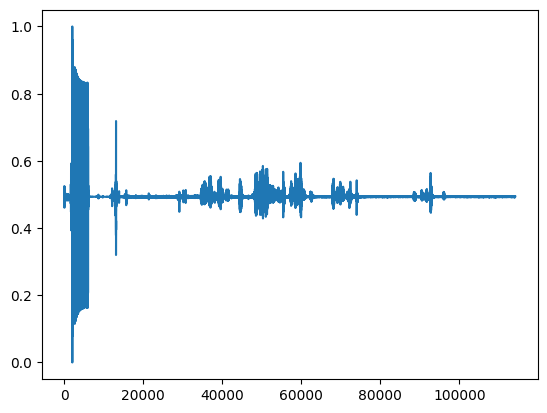

In [11]:
from helpers.transform import TrimAfterTrigger

tat = TrimAfterTrigger()

final_segments = tat.transform(
    audio_dir=MOBILE_AUDIO_DIR,
    sample_rate_target=new_sample_rate,
    synthetic_freq=SYNTHETIC_FREQ,
    downsample_factor=DOWNSAMPLE_FACTOR,
    sigma_smooth=SIGMA_SMOOTH,
    peaks_height=PEAKS_HEIGHT,
    peaks_prominence=PEAKS_PROMINENCE,
    segment_min_duration=MIN_SECS,
)

for i, segment in enumerate(final_segments[0]):
    segment = segment.squeeze()
    duration = len(segment) / mobile_sample_rate

    print(f"#{i+1} ({duration}s): {segment}")
    plt.plot(segment)
    plt.show()